클래스: ['blocked', 'free']
데이터 수: 60


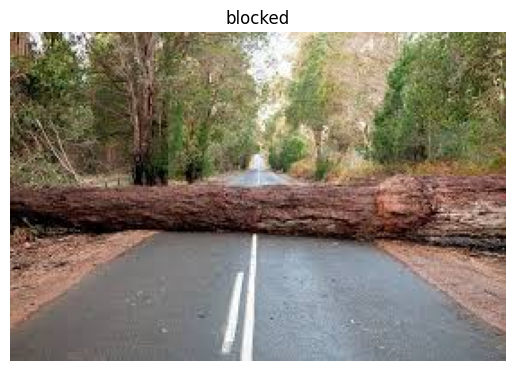

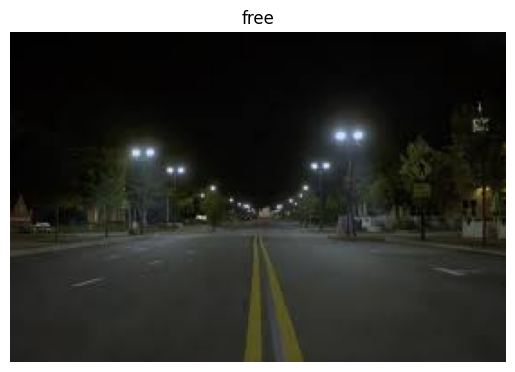

In [6]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os, random
import cv2

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(r"C:\Users\ai\Desktop\jetson-nano-project\dataet_classification", transform=transform)
print("클래스:", dataset.classes)
print("데이터 수:", len(dataset))

# free / blocked 이미지 1장씩 출력
for label in dataset.classes:
    path = os.path.join(dataset.root, label)  # dataset.root 사용
    sample = random.choice(os.listdir(path))
    img = cv2.imread(os.path.join(path, sample))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
    plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# ResNet18 모델 불러오기
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # free/blocked 2클래스
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses, accs = [], []

for epoch in range(3):  # 포폴용 3epoch만
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    losses.append(running_loss)
    accs.append(acc)
    print(f"Epoch {epoch+1}: Loss={running_loss:.2f}, Accuracy={acc:.2f}%")


Device: cpu
Epoch 1: Loss=6.10, Accuracy=70.00%
Epoch 2: Loss=2.28, Accuracy=86.67%
Epoch 3: Loss=7.09, Accuracy=83.33%


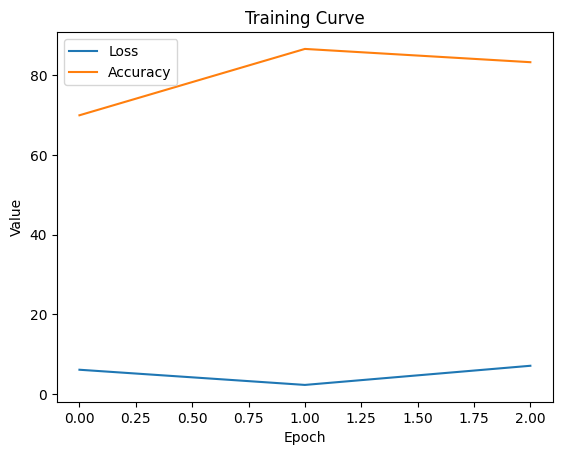

In [9]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Loss")
plt.plot(accs, label="Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Curve")
plt.show()


실제 라벨: free | 예측: free


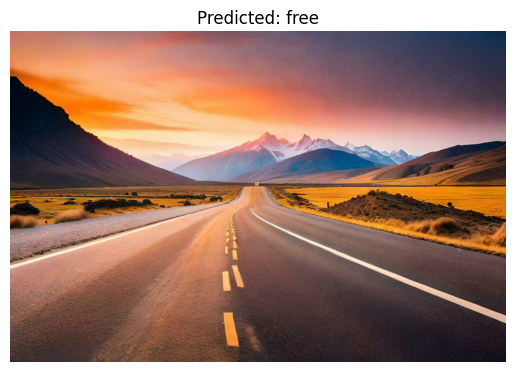

In [11]:
from PIL import Image

model.eval()
img_path, label = dataset.samples[random.randint(0, len(dataset)-1)]
img = Image.open(img_path).convert("RGB")   # ✅ PIL 이미지로 열기

# 전처리
input_img = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_img)
    pred = torch.argmax(output, 1).item()

print("실제 라벨:", dataset.classes[label], "| 예측:", dataset.classes[pred])

plt.imshow(img)
plt.title(f"Predicted: {dataset.classes[pred]}")
plt.axis("off")
plt.show()



In [12]:
import time

dummy_input = torch.randn(1, 3, 224, 224).to(device)

start = time.time()
for _ in range(100):
    _ = model(dummy_input)
end = time.time()

fps = 100 / (end - start)
print(f"추론 속도: {fps:.2f} FPS")


추론 속도: 60.12 FPS
